<a href="https://colab.research.google.com/github/AnishSrivastava/Samsung-Innovation-Campus/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import io
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler , MinMaxScaler , MaxAbsScaler

# Data Loading and Visualization

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
#Load CSV file into PD
credit = pd.read_csv('gdrive/My Drive/credit_card.csv')
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
ROOT = '/content/gdrive/My Drive/My_Folder'
credit.to_csv(ROOT)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


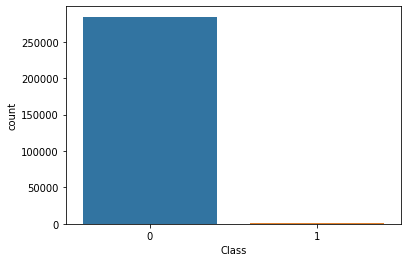

In [ ]:
# Visaulizing Count for each Class
credit.Class.value_counts()
sns.countplot("Class",data=credit)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


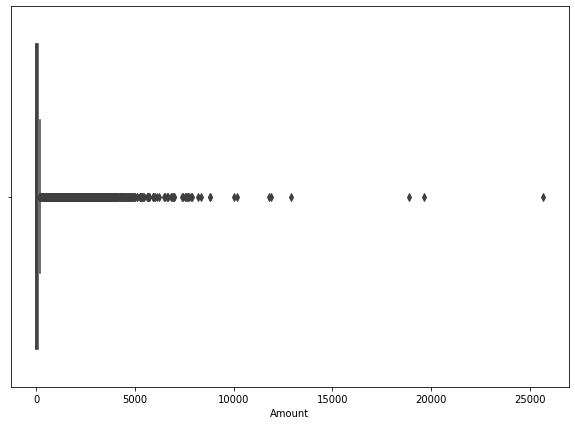

In [ ]:
# Box Plot
amount = credit.iloc[:,-1:]
plt.figure(figsize = (10,7))
sns.boxplot(credit.Amount)

In [ ]:
corrmat = credit.corr()

In [ ]:
mask = np.zeros_like(corrmat, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corrmat[mask] = np.nan
(corrmat
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
V1,0.12,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
V2,-0.01,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
V3,-0.42,-0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
V4,-0.11,-0.00,-0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
V5,0.17,0.00,0.00,-0.00,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
V6,-0.06,-0.00,0.00,0.00,-0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
V7,0.08,-0.00,0.00,0.00,-0.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
V8,-0.04,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
V9,-0.01,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


# Data Processing

In [ ]:
#Scaling the data as the difference between high and low values is large
scaled_data = StandardScaler()
amnt = credit['Amount'].values
credit['Amount'] = scaled_data.fit_transform(amnt.reshape(-1,1))

In [ ]:
#removing unwanted data columns and duplicates
credit.drop(['Time'], axis=1,inplace=True)

In [ ]:
credit.drop_duplicates(subset=None,inplace=True)

In [ ]:
# getting an idea of the data after preprocessing
num_of_transactions = len(credit)
reg_transactions = len(credit[credit.Class == 0])
fraud_transactions = len(credit[credit.Class == 1])
print('Total number of transactions = {}'.format(num_of_transactions))
print('number of normal transactions = {}'.format(reg_transactions))
print('number of fraudulent transactions = {}'.format(fraud_transactions))

Total number of transactions = 275663
number of normal transactions = 275190
number of fraudulent transactions = 473


In [ ]:
#Splitting data and labels for IF and LOF
cols = credit.columns.tolist()
cols = [c for c in cols if c not in ['Class']]
tar = 'Class'

data = credit[cols]
labels = credit[tar]
data.replace([np.inf, -np.inf], np.nan, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


# Data Augmentation and training & testing using KNN Algorithm

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('Normal transactions: ', round(credit['Class'].value_counts()[0]/len(credit) * 100,2), '% of the dataset')
print('Fraudulent transactions: ', round(credit['Class'].value_counts()[1]/len(credit) * 100,2), '% of the dataset')

Normal transactions:  99.83 % of the dataset
Fraudulent transactions:  0.17 % of the dataset


In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

In [ ]:
#We are creating a sub-sample for testing purposes. We’re going to test our models on the original testing set and not on the set that would be created by the sampling technique
XX = credit.drop('Class', axis=1)
yy = credit['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(XX, yy):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = XX.iloc[train_index], XX.iloc[test_index]
    original_ytrain, original_ytest = yy.iloc[train_index], yy.iloc[test_index]

Train: [ 29560  29630  29644 ... 275660 275661 275662] Test: [    0     1     2 ... 55191 55192 55193]
Train: [     0      1      2 ... 275660 275661 275662] Test: [ 29560  29630  29644 ... 110309 110310 110311]
Train: [     0      1      2 ... 275660 275661 275662] Test: [ 75977  77780  77791 ... 165453 165454 165455]
Train: [     0      1      2 ... 275660 275661 275662] Test: [146004 146007 146014 ... 220548 220549 220550]
Train: [     0      1      2 ... 220548 220549 220550] Test: [206988 208486 208598 ... 275660 275661 275662]


In [ ]:
#converting data into Numpy arrays to feed into the model
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

In [ ]:
#random undersampling technique(randomly deletes datapoints from the majority class)
#This is done before cross_validation
#shuffling the data beforehand:
credit = credit.sample(frac=1)

In [ ]:
fraud_credit = credit.loc[credit['Class'] == 1]
non_fraud_credit = credit.loc[credit['Class'] == 0][:473] #taking 492 non_fraudulent cases

#creating the new dataset by appending new reduced points: -Anish
normal_distributed_credit = pd.concat([fraud_credit, non_fraud_credit])
new_credit = normal_distributed_credit.sample(frac=1, random_state=42)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

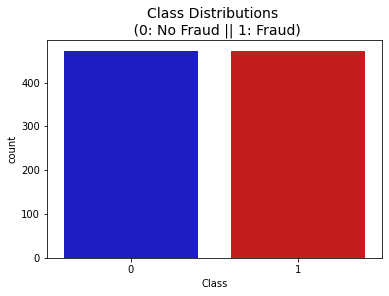

In [ ]:
#visualizing the new dataset after undersampling
import matplotlib.pyplot as plt
colors = ["#0101DF", "#DF0101"]
sns.countplot('Class', data=new_credit, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [ ]:
#forming a correlation matrix to check which columns are negatively or positively correlated.
corrmatt = new_credit.corr()

In [ ]:
mask_2 = np.zeros_like(corrmatt, dtype=bool)
mask_2[np.triu_indices_from(mask_2)] = True
corrmatt[mask_2] = np.nan
(corrmatt
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
V1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
V2,-0.75,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
V3,0.86,-0.84,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
V4,-0.60,0.65,-0.75,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
V5,0.84,-0.79,0.85,-0.55,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
V6,0.35,-0.31,0.48,-0.42,0.28,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
V7,0.87,-0.81,0.88,-0.70,0.82,0.33,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
V8,-0.22,0.14,-0.29,0.14,-0.30,-0.52,-0.04,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
V9,0.63,-0.69,0.75,-0.78,0.65,0.34,0.76,-0.08,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
V10,0.71,-0.75,0.84,-0.77,0.73,0.42,0.86,-0.10,0.85,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [ ]:
#Training the new dataset using KNN Algorithm

In [ ]:
X = new_credit.drop('Class', axis=1)
y = new_credit['Class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
                                                    

In [ ]:
#converting data to Numpy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
#getting cross validation score -Anish
from sklearn.model_selection import cross_val_score
training_score = cross_val_score(KNN, X_train, y_train, cv=5)
print("KNeighborsClassifier Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

KNeighborsClassifier Has a training score of 93.0 % accuracy score


0.9876085613576074


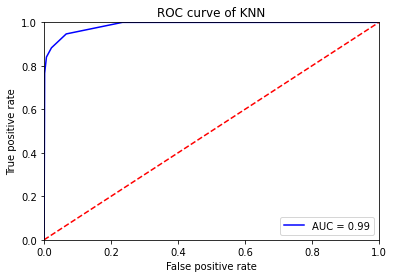

In [ ]:
#calculating auroc score for knn model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_scores = KNN.predict_proba(original_Xtest)
fpr, tpr, threshold = roc_curve(original_ytest, y_scores[:,1])
roc_auc = auc(fpr, tpr)
print(roc_auc)
#visualising the roc curve
plt.title('ROC')
plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title('ROC curve of KNN')
plt.show()

In [ ]:
#forming the confusion matrix
y_pred = KNN.predict(original_Xtest)
conf_mat = confusion_matrix(original_ytest, y_pred)
print(conf_mat)

[[53825  1213]
 [   11    83]]


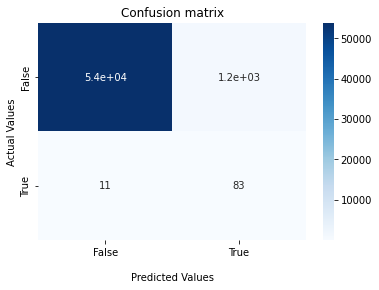

In [ ]:
#visualising the confusion matrix
import seaborn as sns
ax = sns.heatmap(conf_mat, annot = True, cmap='Blues')
ax.set_title('Confusion matrix')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

# Initial Training - Isolation Forest(IF), Local Outlier Factor(LOF)


Isolation Forest

In [ ]:
iso_for = IsolationForest(random_state=42)
iso_for.fit(data)
scores_pred = iso_for.decision_function(data)
pred_if = iso_for.predict(data)
pred_if[pred_if == 1] = 0
pred_if[pred_if == -1] = 1
n_errors = (pred_if != labels).sum()
acc_if = accuracy_score(labels, pred_if)
acc_if =  np.round(acc_if,3)*100
print("Isolation Forest Accuracy:",acc_if)

Isolation Forest Accuracy: 96.1


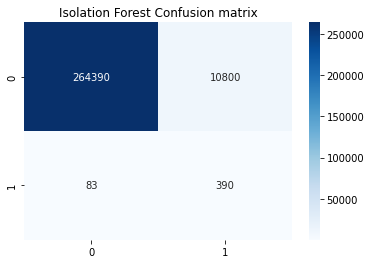

In [ ]:
# Plotting confusion matrix
vals = [0,1]
cm_if = confusion_matrix(labels,pred_if,labels=vals)
sns.heatmap(cm_if, annot=True,fmt="d",cmap='Blues')
plt.title('Isolation Forest Confusion matrix')
plt.show()

Local Outlier Factor

In [ ]:
clf = LocalOutlierFactor()
pred_lof = clf.fit_predict(data)
scores_pred = clf.negative_outlier_factor_
pred_lof[pred_lof == 1] = 0
pred_lof[pred_lof == -1] = 1
n_errors = (pred_lof != labels).sum()
acc_lof = accuracy_score(labels, pred_lof)
acc_lof =  np.round(acc_lof,3)*100
print("LOF Accuracy:",acc_lof)

LOF Accuracy: 94.3


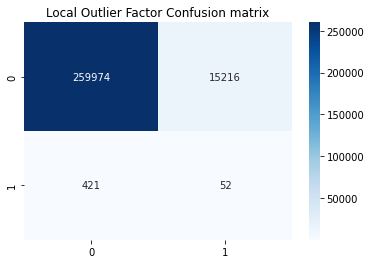

In [ ]:
cm_lof = confusion_matrix(labels,pred_lof,labels=vals)
sns.heatmap(cm_lof, annot=True,fmt="d",cmap='Blues')
plt.title('Local Outlier Factor Confusion matrix')
plt.show()

Due to heavily imbalanced dataset, accuracy is not a suitable measure of model performance. TPR, FPR, AUROC metrics are better suited for anomaly detection

In [ ]:
fpr_if, tpr_if,_= metrics.roc_curve(labels, pred_if, pos_label=1)
auroc_if = metrics.auc(fpr_if, tpr_if)
print("Isolation Forest True Positive Rate:",tpr_if[1])
print("Isolation Forest False Positive Rate:",fpr_if[1])
print("Isolation Forest AUROC:",auroc_if)

Isolation Forest True Positive Rate: 0.8245243128964059
Isolation Forest False Positive Rate: 0.039245612122533524
Isolation Forest AUROC: 0.8926393503869362


In [ ]:
fpr_lof, tpr_lof,_= metrics.roc_curve(labels, pred_lof, pos_label=1)
auroc_lof = metrics.auc(fpr_lof, tpr_lof)
print("Local Outlier Factor True Positive Rate:",tpr_lof[1])
print("Local Outlier Factor False Positive Rate:",fpr_lof[1])
print("Local Outlier Factor AUROC:",auroc_lof)

Local Outlier Factor True Positive Rate: 0.10993657505285412
Local Outlier Factor False Positive Rate: 0.05529270685708056
Local Outlier Factor AUROC: 0.5273219340978867


Initial Performance Visualization

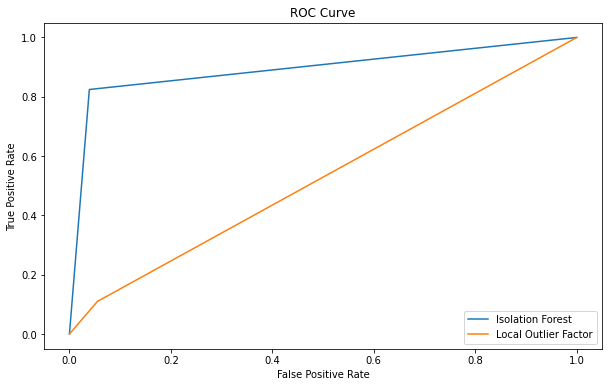

In [ ]:
# Initial model performance comparison
fig,(ax1) = plt.subplots(1,1);fig.set_size_inches(10, 6)
ax1.plot(fpr_if,tpr_if, label = 'Isolation Forest');ax1.plot(fpr_lof,tpr_lof, label = 'Local Outlier Factor'); ax1.legend(fontsize=10); ax1.title.set_text('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.legend(loc = 'lower right')
plt.show()

Initial results show Local Outlier Factor is unable to distinguish anomalies with an AUROC of 0.527. Further tuning is needed to improve the algorithm performance.

# Hyperparameter Tuning


Isolation Forest

In [ ]:
def iso_for(X,Y,trees=None,samples=None,outlier_frac=None):
  if trees != None:
    iso_for = IsolationForest(n_estimators = t,random_state=42)
  elif samples!= None:
    iso_for = IsolationForest(max_samples = samples,random_state=42)
  else:
    iso_for = IsolationForest(contamination = outlier_frac,random_state=42)

  iso_for.fit(data)
  scores_pred = iso_for.decision_function(data)
  pred_if = iso_for.predict(data)
  pred_if[pred_if == 1] = 0
  pred_if[pred_if == -1] = 1
  n_errors = (pred_if != labels).sum()
  
  fpr_if, tpr_if,_= metrics.roc_curve(labels, pred_if, pos_label=1)
  auroc_if = metrics.auc(fpr_if, tpr_if)
  return auroc_if

In [ ]:
no_trees = list(range(50,350,50))
max_samples = [32,64,128,256]
contam = [0.01,0.05,0.1,0.15]

In [ ]:
auroc_trees = []
for t in no_trees:
  auc = iso_for(data,labels,t)
  auroc_trees.append(auc)

max_auc = max(auroc_trees)
idx = auroc_trees.index(max_auc)
max_trees = no_trees[idx]

print("Maximum AUROC obtained is:",max_auc)

In [ ]:
auroc_samples=[]
for s in max_samples:
  auc = iso_for(data,labels,None,s)
  auroc_samples.append(auc)

max_auc = max(auroc_samples)
idx = auroc_samples.index(max_auc)
m_samples = max_samples[idx]

print("Maximum AUROC obtained is:",max_auc)


In [ ]:
auroc_contam=[]
for c in contam:
  auc = iso_for(data,labels,None,None,c)
  auroc_contam.append(auc)

max_auc = max(auroc_contam)
idx = auroc_contam.index(max_auc)
max_contam = contam[idx]

print("Maximum AUROC obtained is:",max_auc)

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3);fig.set_size_inches(20, 5)
ax1.plot(no_trees,auroc_trees);ax2.plot(max_samples,auroc_samples);ax3.plot(contam,auroc_contam)
ax1.set_xlabel('Number of Trees');ax2.set_xlabel('Sub-Sampling Size');ax3.set_xlabel('Contamination Ratio')
ax1.set_ylabel('AUC');ax2.set_ylabel('AUC');ax3.set_ylabel('AUC')
plt.show()

In [ ]:
param_grid = {'n_estimators': [100,200,300],'max_samples': [64,128,256], 'contamination' : [0.1, 0.05,0.2] }

auroc_score = metrics.make_scorer(metrics.roc_auc_score)
if_tuned = IsolationForest()
clf = GridSearchCV(if_tuned, param_grid, scoring=auroc_score, refit=True,cv=10)
clf.fit(data,labels)

Local Outlier Factor

In [ ]:
no_neighbors = [50,100,150,200,250,300,350,400]

In [ ]:
auroc_neighbors = []

In [ ]:
clf = LocalOutlierFactor(n_neighbors=400)
pred_lof = clf.fit_predict(data)
scores_pred = clf.negative_outlier_factor_
pred_lof[pred_lof == 1] = 0
pred_lof[pred_lof == -1] = 1
n_errors = (pred_lof != labels).sum()

fpr_lof, tpr_lof,_= metrics.roc_curve(labels, pred_lof, pos_label=1)
auroc_lof = metrics.auc(fpr_lof, tpr_lof)

In [ ]:
auroc_neighbors.append(auroc_lof)

In [ ]:
print(auroc_neighbors)

[0.537525028834585, 0.5340587287491625, 0.5532410204074263, 0.6213285427934588, 0.7283064508880162, 0.7466275193913688, 0.7829062711006434]


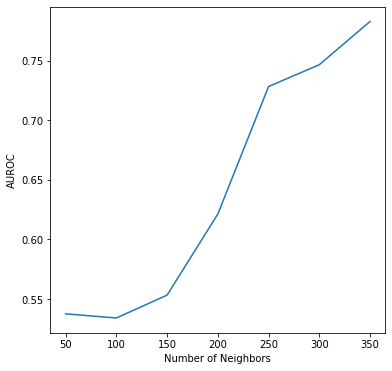

In [ ]:
fig,(ax1) = plt.subplots(1,1);fig.set_size_inches(6, 6)
ax1.plot(no_neighbors,auroc_neighbors)
plt.xlabel('Number of Neighbors')
plt.ylabel('AUROC') 
plt.show()